In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
%matplotlib qt

In [51]:
# missing libraries can be installed with pip.
# For example, uncomment and execute the following line:
# pip install sympy

### Helper functions

In [52]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

def getXYFromNormalVector(n, d, D):
    r_C = np.array([0, 0, d]) # center of rotation
    # xy coordinate system defined with respect to 90° incidence angle
    n_0 = normalize(np.array([0,0,1]))
    r_OP_0 = np.array([0,0, -1])

    # target plane
    n_t = np.array([0,0,1])
    r_OT = np.array([0,0,-D]) 
    
    scaling = D*np.tan(np.deg2rad(50))
    
    r_OP_2 = getSpotOnTargetPlane(n, r_C, d, n_0, r_OP_0, r_OT, n_t)
    x = r_OP_2[0]/scaling
    y = r_OP_2[1]/scaling
    return x,y

def getNormalVectorFromXY(x,y, d):
    #distance d between center of rotation and mirror surface (mm)
    if d==0:
        return getNormalVectorFromXY_d0(x,y) # faster
    
    # Parameters as used in OQC calibration
    r_C = np.array([0, 0, d]) # center of rotation
    n_0 = np.array([0,0,1])
    r_OP_0 = np.array([0,0, -1])

    # target plane
    D = 90 # Distance center of rotation to target plane, mm
    n_t = np.array([0,0,1])
    r_OT = np.array([0,0,-D])
    
    n_m1, n_m2 = sy.symbols("n_m1 n_m2")
    n_m = sy.matrices.Matrix([n_m1, n_m2, -sy.sqrt(1-(n_m1**2+n_m2**2))])
    r_OP_2 = sy_getSpotOnTargetPlane(n_m, r_C, d, n_0, r_OP_0, r_OT, n_t)
    
    A_TI = np.diag([1,1,1])
    I_r_TP_2 = r_OP_2 - sy.matrices.Matrix(r_OT)
    T_r_TP_2 = np.dot(A_TI, I_r_TP_2)
    T_r_TP_2 = sy.simplify(T_r_TP_2)
    
    
    scaling = D*np.tan(50/180*np.pi)
    res = sy.solvers.solvers.nsolve((T_r_TP_2[0][0]-x*scaling,
                                     T_r_TP_2[1][0]-y*scaling),
                                    (n_m1, n_m2), (0, 0))
    n_x = float(res[0])
    n_y = float(res[1])
    
    n = np.array([n_x, n_y, -np.sqrt(1-(n_x**2+n_y**2))])
    
    return n

def getNormalVectorFromXY_d0(x,y): 
    #approximation for centered beam and d -> 0
    n0 = np.array([0,0, 1]) # xy coordinate system defined with respect to 90° incidence angle
    
    r = normalize(np.array([x, y, -1/np.tan(np.deg2rad(50))])) # direction of reflected beam
    return normalize(r - n0)

def getNormalVectorFromTargetXY_d0(x_t, y_t, A_IT, D, n0):
    #approximation for centered beam and d -> 0
    n_t = np.dot(A_IT, np.array([0,0,1]))
    r_OT = np.dot(A_IT, np.array([0,0,-D]))
    T_r_TP_2 =  np.array([x_t, y_t, 0])
    I_r_TP_2 =  np.dot(A_IT, T_r_TP_2)
    r_OP_2 = r_OT + I_r_TP_2
    n_1 = normalize(r_OP_2)
    
    n_m = normalize(n_1-n_0)
    return n_m

def getSpotOnTargetPlane(n_m, r_C, d, n_0, r_OP_0, r_OT, n_t):
    #r_M = r_C + d * n_m # center of mirror surface
    
    # intersection of incoming beam with mirror (beam clipping not checked)
    t_1 = (np.dot(r_C-r_OP_0, n_m)+d) / np.dot(n_0, n_m)
    r_OP_1 = r_OP_0 + t_1 * n_0 
    
    n_1 = n_0 - 2*np.dot(n_0, n_m)*n_m # reflected beam
    
    # intersection of reflected beam with target plane (beam clipping not checked)
    # no check of whether the intersection happens in the correct half-space (t2 > 0)
    t_2 = np.dot(r_OT-r_OP_1, n_t) / np.dot(n_1, n_t)
    if t_2 < 0:
        print('Warning: intersection in wrong half-space')
    r_OP_2 = r_OP_1 + t_2 * n_1
    return r_OP_2

def sy_getSpotOnTargetPlane(n_m, r_C, d, n_0, r_OP_0, r_OT, n_t):
    # same as above but for symbolic calculations
    #r_M = r_C + d * n_m # center of mirror surface
    n_m = sy.matrices.Matrix(n_m)
    r_C = sy.matrices.Matrix(r_C)
    n_0 = sy.matrices.Matrix(n_0)
    r_OP_0 = sy.matrices.Matrix(r_OP_0)
    r_OT = sy.matrices.Matrix(r_OT)
    n_t = sy.matrices.Matrix(n_t)
    
    t_1 = (n_m.dot(r_C-r_OP_0)+d) / n_0.dot(n_m)
    r_OP_1 = r_OP_0 + t_1 * n_0 # center point of incoming beam on mirror
    
    n_1 = n_0 - 2*n_0.dot(n_m)*n_m # reflected beam
    
    t_2 = n_t.dot(r_OT-r_OP_1) / n_1.dot(n_t)
    r_OP_2 = r_OP_1 + t_2 *n_1
    return r_OP_2


def grid(x_min, x_max, y_min, y_max, NxNy):
    
    if isinstance(NxNy, tuple):
        Nx, Ny = NxNy
    else:
        Nx = NxNy
        Ny = NxNy
    
    x_grid = np.linspace(x_min, x_max, endpoint=True, num=Nx)
    y_grid = np.linspace(y_min, y_max, endpoint=True, num=Ny)
    xx, yy = np.meshgrid(x_grid, y_grid)
    x_grid = xx.ravel()
    y_grid = yy.ravel()
    
    return x_grid, y_grid

def circleBoundedGrid(x_min, x_max, y_min, y_max, N):
    x_grid, y_grid = grid(x_min, x_max, y_min, y_max, N)
    x_bounded = []
    y_bounded = []
    
    # discard grid-points outside unit circle
    for x,y in zip(x_grid, y_grid):
        if x**2+y**2 <= 1:
            x_bounded.append(x)
            y_bounded.append(y)
    return np.array(x_bounded), np.array(y_bounded)    
    

## Note

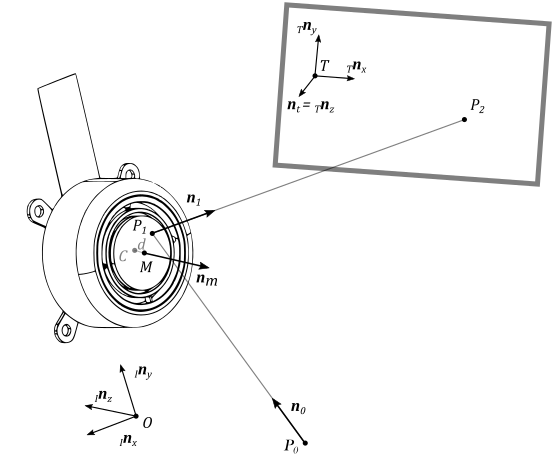

In [57]:
from IPython.display import Image
Image("sketch.png")

# The calculations follow the chapter on coordiante transformations in https://www.optotune.com/s/Optotune-MR-E-2-Development-Kit-operation-manual.pdf
# In most cases the assumption 𝑃1 = 𝑀 = 𝐶 yields accurate enough results. -> use d=0 and make the incoming beam hit the mirror in the center
# For the general case, the sympy library is used to solve the equations, which takes longer to compute.

## Define Geometry

### 0° nominal AOI

In [6]:
# select and if necessary adapt the code below to match your geometry

# Mirror
d = 0 # distance center of rotation to mirror surface, mm
r_C = np.array([0, 0, d]) # center of rotation, origin is at mirror center when in mirror in neutral position
# incoming beam
n_0 = normalize(np.array([0,0,1]))
r_OP_0 = np.array([0,0, -1])

# target plane
D = 1000 # Distance center of rotation to target plane, mm
A_TI = np.diag([1,1,1])
A_IT = np.transpose(A_TI)
n_t = np.dot(A_IT, np.array([0,0,1]))
r_OT = np.dot(A_IT, np.array([0,0,-D]))


# target plane at 45°
#D = 1000 # Distance center of rotation to target plane, mm
#alpha = np.deg2rad(45)
#A_TI = np.array([[np.cos(alpha), 0 ,np.sin(alpha)], 
#                  [0, 1 ,0], 
#                  [-np.sin(alpha), 0 , np.cos(alpha)]])
#A_IT = np.transpose(A_TI)
#n_t = np.dot(A_IT, np.array([0,0,1]))
#r_OT = np.dot(A_IT, np.array([0,0,-D]))

### 45° nominal AOI

In [7]:
# select and if necessary adapt the code below to match your geometry

# Mirror
d = 0 # distance center of rotation to mirror surface, mm
r_C = np.array([0, 0, d]) # center of rotation, origin


# incoming beam in xz plane
#n_0 = normalize(np.array([1,0,1]))
#r_OP_0 = np.array([-1,0, -1])
##target plane
#D = 1000 # Distance center of rotation to target plane, mm
#alpha = np.deg2rad(45)
#
#A_TI = np.array([[np.cos(alpha), 0, np.sin(alpha)], 
#                 [0, 1, 0], 
#                 [-np.sin(alpha), 0, np.cos(alpha)]])
#
#A_IT = np.transpose(A_TI)
#n_t = np.dot(A_IT, np.array([0,0,1]))
#r_OT = np.dot(A_IT, np.array([0,0,-D]))

# incoming beam in yz plane
n_0 = normalize(np.array([0,-1,1]))
r_OP_0 = np.array([0,1, -1])

# target plane
D = 1000 # Distance mirror center (undeflected) to target plane, mm

alpha = np.deg2rad(45)
A_TI = np.array([[ 1, 0 ,0], 
                [ 0, np.cos(alpha), -np.sin(alpha)], 
                [ 0, np.sin(alpha), np.cos(alpha)]])
A_IT = np.transpose(A_TI)
n_t = np.dot(A_IT, np.array([0,0,1]))
r_OT = np.dot(A_IT, np.array([0,0,-D]))


## Mirror Coordinates -> Target Plane Coordinates

In [8]:
# resolution
N = 51

gamma = np.linspace(0, 2*np.pi, N)
x_unitcircle = np.cos(gamma)
y_unitcircle = np.sin(gamma)

x_grid,y_grid = circleBoundedGrid(-1, 1, -1, 1, N) # NxN

x_target = [] # to be calculated coordinates
y_target = [] # to be calculated coordinates

# SELECT WHAT TO PLOT
x_plot = x_grid
y_plot = y_grid

n_plot = len(x_plot)
progress = 0 # variable used for "progress bar"

for i, (x,y) in enumerate(zip(x_plot, y_plot)):
    n_m = getNormalVectorFromXY(x,y, d)

    r_OP_2 = getSpotOnTargetPlane(n_m, r_C, d, n_0, r_OP_0, r_OT, n_t)
    
    I_r_TP_2 = r_OP_2-r_OT
    T_r_TP_2 = np.dot(A_TI, I_r_TP_2)
    x_target.append(T_r_TP_2[0])
    y_target.append(T_r_TP_2[1])
    
    # progress bar:
    if (i+1)/n_plot> progress+0.1:
        progress = i/n_plot
        print(str(int(round(progress,1)*100))+'%')
    
plt.figure(1)   
plt.plot(x_plot, y_plot, '.')
plt.axis('equal')
plt.xlabel('Mirror coordinate: x')
plt.ylabel('Mirror coordinate: y')
plt.grid('True')

plt.figure(2)


plt.plot(x_target, y_target, 'b.', label='Projected positions')
plt.plot(x_unitcircle*D*np.tan(np.deg2rad(50)), y_unitcircle*D*np.tan(np.deg2rad(50)),'grey', label='100° FOV')

plt.axis('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
#plt.xlabel('Target plane: x (mm)')
#plt.ylabel('Target plane: y (mm)')
plt.grid('True')
plt.legend(loc='best')
plt.tight_layout()

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


## Target Plane Coordinates -> Mirror Coordinates

In [33]:
# define pattern in target plane
N = 50
L = 700 # mm

gamma = np.linspace(0, 2*np.pi, N)
x_unitcircle = np.sin(gamma)
y_unitcircle = np.cos(gamma)
x_circle = L* x_unitcircle
y_circle = L* y_unitcircle

x_grid, y_grid = grid(-1, 1, -1, 1, N)
x_grid *= L
y_grid *= L

In [34]:
# run this cell a second time, with the follwing code uncommented, to exclude non-feasible FOV portions
#x_grid = x_grid[i_feasible]
#y_grid = y_grid[i_feasible]

x_target = x_grid
y_target = y_grid

    
x_input = [] # to be calculated mirror coordinates
y_input = [] # to be calculated mirror coordinates

if d==0 and abs(np.dot(r_OP_0, n_0)/np.linalg.norm(r_OP_0) + 1) < 1e-9:
    # calculation is simple if d is 0 and incoming beam hits mirror in the center (origin)
    simpleMode = True
else:
    simpleMode = False
    n_m1, n_m2 = sy.symbols("n_m1 n_m2")
    n_m = sy.matrices.Matrix([n_m1, n_m2, -sy.sqrt(1-(n_m1**2+n_m2**2))])
    r_OP_2 = sy_getSpotOnTargetPlane(n_m, r_C, d, n_0, r_OP_0, r_OT, n_t)
    I_r_TP_2 = r_OP_2 - sy.matrices.Matrix(r_OT)
    T_r_TP_2 = np.dot(A_TI, I_r_TP_2)
    T_r_TP_2 = sy.simplify(T_r_TP_2)

    
    

progress = 0
n_target = len(x_target)

for i, (x_t, y_t) in enumerate(zip(x_target, y_target)):
    if simpleMode:
        n = getNormalVectorFromTargetXY_d0(x_t, y_t, A_IT, D, n_0)
        x,y = getXYFromNormalVector(n, 0, 90) # D is arbitrary for d==0
    
    else:
        res = sy.solvers.solvers.nsolve((T_r_TP_2[0][0]-x_t,
                                         T_r_TP_2[1][0]-y_t),
                                        (n_m1, n_m2), (0, 0))
        n_x = float(res[0])
        n_y = float(res[1])

        n = np.array([n_x, n_y, -np.sqrt(1-n_x**2-n_y**2)])
        x,y = getXYFromNormalVector(n, d, 90)
        
    x_input.append(x)
    y_input.append(y)
    
    if (i+1)/n_target> progress+0.1:
        progress = i/n_target
        print(int(round(progress,1)*100), '%')

# get indices for feasible points:
i_feasible = []    
# discard grid-points outside unit circle
for i, (x,y) in enumerate(zip(x_input, y_input)):
    if x**2+y**2 <= 1:
        i_feasible.append(i)
    
    
plt.figure(3)
plt.plot(x_target, y_target, '.')
plt.axis('equal')
plt.grid('True')
plt.xlabel('Target plane: x (mm)')
plt.ylabel('Target plane: y (mm)')



plt.figure(4)
plt.plot(x_input, y_input, '.', label='mirror coordinates')
plt.plot(x_unitcircle, y_unitcircle, label='travel limit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.grid('True')

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %


## Euler Angles -> Target Plane Coordinates

In [42]:
# euler angles
N = 12
alpha = np.pi/180*np.linspace(-25,25,20)
beta = np.linspace(-12.5*np.pi/180, 12.5*np.pi/180, N, endpoint=True)


alpha, beta = np.meshgrid(alpha, beta)
alpha_scan = alpha.ravel()
beta_scan = beta.ravel()

x_target = []
y_target = []

n_plot = len(beta_scan)

for i, (alpha, beta) in enumerate(zip(alpha_scan, beta_scan)):
    n_m = np.array([-np.cos(beta)*np.sin(alpha), np.sin(beta), -np.cos(beta)*np.cos(alpha)])
    
    r_OP_2 = getSpotOnTargetPlane(n_m, r_C, d, n_0, r_OP_0, r_OT, n_t)
    
    I_r_TP_2 = r_OP_2-r_OT
    T_r_TP_2 = np.dot(A_TI, I_r_TP_2)
    x_target.append(T_r_TP_2[0])
    y_target.append(T_r_TP_2[1])
    
plt.figure(1)   
plt.plot(alpha_scan*180/np.pi, beta_scan*180/np.pi, '.')
plt.axis('equal')
plt.xlabel('Outer gimbal angle (°)')
plt.ylabel('Inner gimbal angle (°)')
plt.grid('True')

plt.figure(2)
plt.plot(x_target, y_target, 'b.')
#plt.plot(x_unitcircle*D*np.tan(np.deg2rad(50)), y_unitcircle*D*np.tan(np.deg2rad(50)), label='100° FOV')



plt.axis('equal')
plt.xlabel('Target plane: x (mm)')
plt.ylabel('Target plane: y (mm)')
plt.grid('True')
#plt.legend()